<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/plate_recognizer/notebooks/data_centric_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Centric Competition

## Overview
Data Centric Competition is the first AI competition where you focus exclusively on manipulating the datasets instead of models. It is organized by DeepLearning.AI and here are the links:

- [main page](https://https-deeplearning-ai.github.io/data-centric-comp/?utm_source=thebatch&utm_medium=newsletter&utm_campaign=dc-ai-competition&utm_content=dl-ai)
- [Guidelines](https://worksheets.codalab.org/worksheets/0x7a8721f11e61436e93ac8f76da83f0e6)
- [CodaLab](https://codalab-worksheets.readthedocs.io/en/latest/): this is the workspace where you create a worksheet, build datasets, etc.

The data consists of handwritten Roman numerals `i` through `x`. Zero was not invented in Roman times so no zeros.

Three datasets are provided in three folders: namely, train, val, and label_book. Two python scripts were given as starters:
- convert.py: a sample code to load images and resize
- train.py: a sample code to load the datasets and train the model.

## Goal
The goal is to train ResNet50 model with the training data and get a high accuracy.

## Datasets
The initial survey of the datasets is as follows:

- Training set: 2067 color images with the shape (232, 232, 3)
- Validation set: 813 iamges
- Test set (label_book): 

The labels are provided by the folder name: e.g., 'i' has all the images of i, etc.

## EDA
The convert method provided converts the image to grayscale and quantizes for easier processing. The size is also reduced to 32x32. This makes the resulting image quite distorted in some cases. For instance, one image of 'iv' looks something between 'iii' and 'iv'


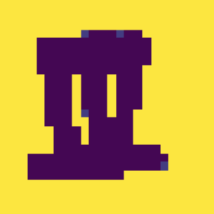

PCA and Clustering of the training set shows quite overlapped features. This explains poor test results from the default model: 51.92%

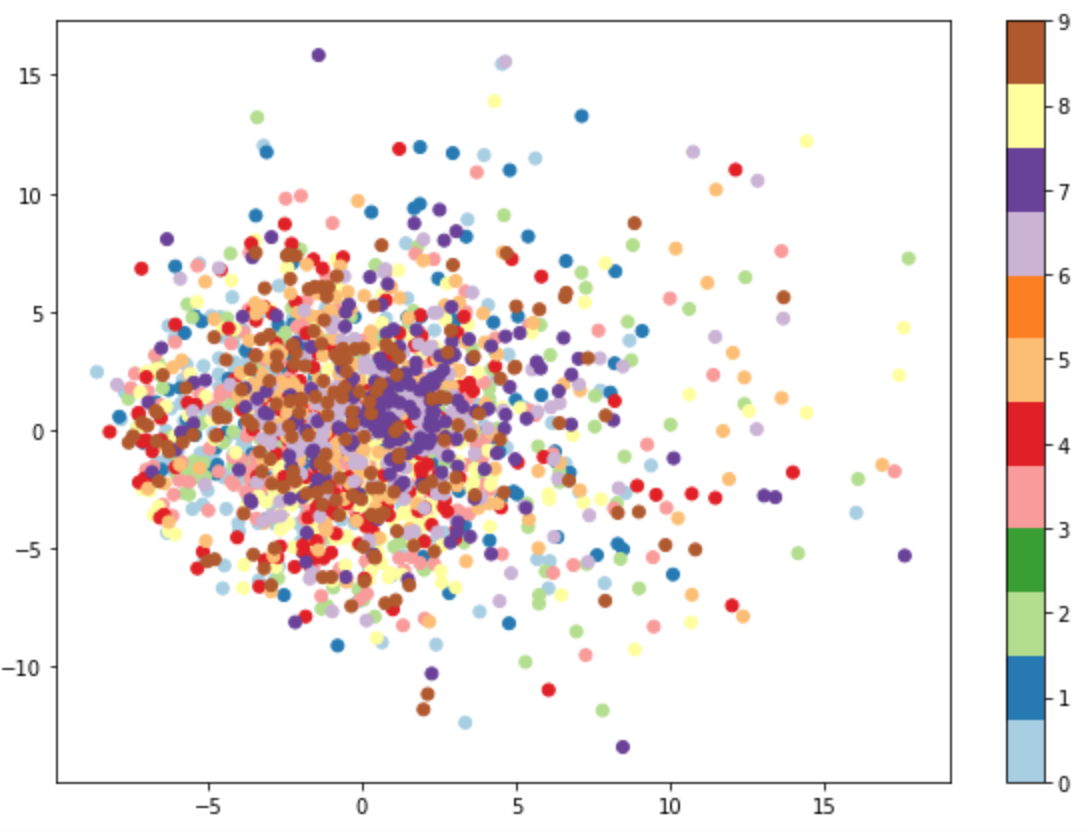

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/changsin/FSDL

Cloning into 'FSDL'...
remote: Enumerating objects: 950, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 950 (delta 55), reused 30 (delta 14), pack-reused 860
Receiving objects: 100% (950/950), 109.38 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (619/619), done.


In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from importlib.util import find_spec
if find_spec("plate_recognizer") is None:
    import sys
    sys.path.append('..')

from FSDL.plate_recognizer.data.cluster import Cluster

import os
import glob

DATA_ROOT = "./drive/MyDrive/data/DataCentric/"
CLASS_NAMES = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
IMAGE_SIZE = 32

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def glob_files(path):
    search_string = os.path.join(path,'*')
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

In [ ]:
import cv2


def load_images(path):
  paths = glob_files(path)

  X_raw = []
  for file in paths:
    image = cv2.imread(file)
    image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
    X_raw.append(np.array(image))

  return np.array(X_raw)

X_train_raw = load_images(DATA_ROOT + 'train/')

## Convert to grayscale and normalize
Since the images are handwritten Roman numerals in white background, it is better to convert them to grayscale and then normalize to reduce the features

In [ ]:
# # official convert_images method
# def convert_images(input_folder, output_folder):
#     Path(output_folder).mkdir(parents=True, exist_ok=True)
#     input_files = glob(os.path.join(input_folder, "*.png"))
#     for f in input_files:
#         image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
#         # quantize
#         image = (image // 43) * 43
#         image[image > 43] = 255
#         cv2.imwrite(os.path.join(output_folder, os.path.basename(f)), image)

In [ ]:
def quantize(X):
  quantized = []
  for x in X:
    x = (x // 43) * 43
    x[x > 43] = 255
    quantized.append(x)

  return np.array(quantized)

In [ ]:
X_train_gray = np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X_train_raw])

X_train_quantized = quantize(X_train_gray)
X_train = X_train_quantized / 255.0

## Load Validation data

In [ ]:
def prepare_data(path):
  X_raw = load_images(path)
  X_gray = np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X_raw])

  X_quantized = quantize(X_gray)
  X = X_quantized / 255.0

  return X

X_val = prepare_data(DATA_ROOT + 'val/')

In [ ]:
Y_val = load_labels(DATA_ROOT + 'val/')
Y_val.shape

(813,)

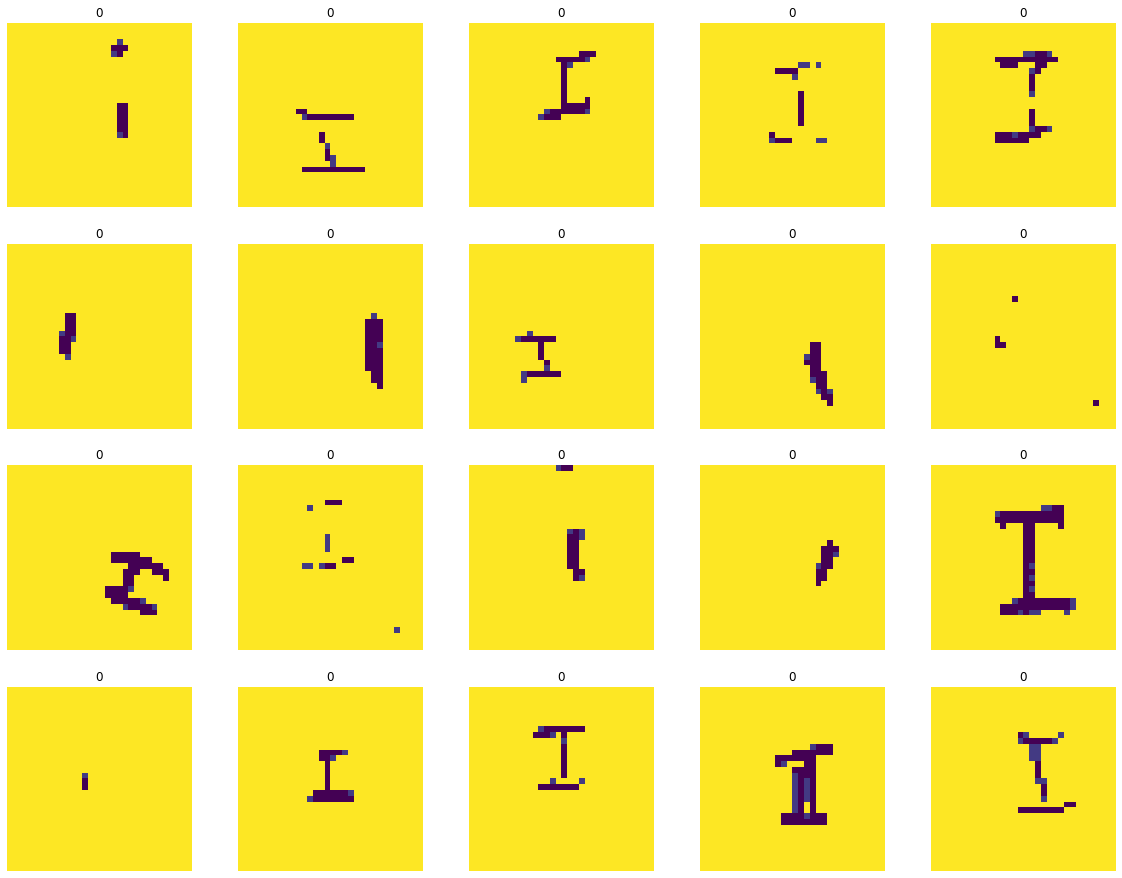

In [ ]:
plot_data(X_val, Y_val)

In [ ]:
LABELS = [ 'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']

def load_labels(path):
  paths = glob_files(path)

  Y = []
  for file in paths:
    y = file.split('/')[-2]
    id = LABELS.index(y)
    Y.append(id)

  return np.array(Y)

Y_train = load_labels(DATA_ROOT + 'train/')

## Load test data

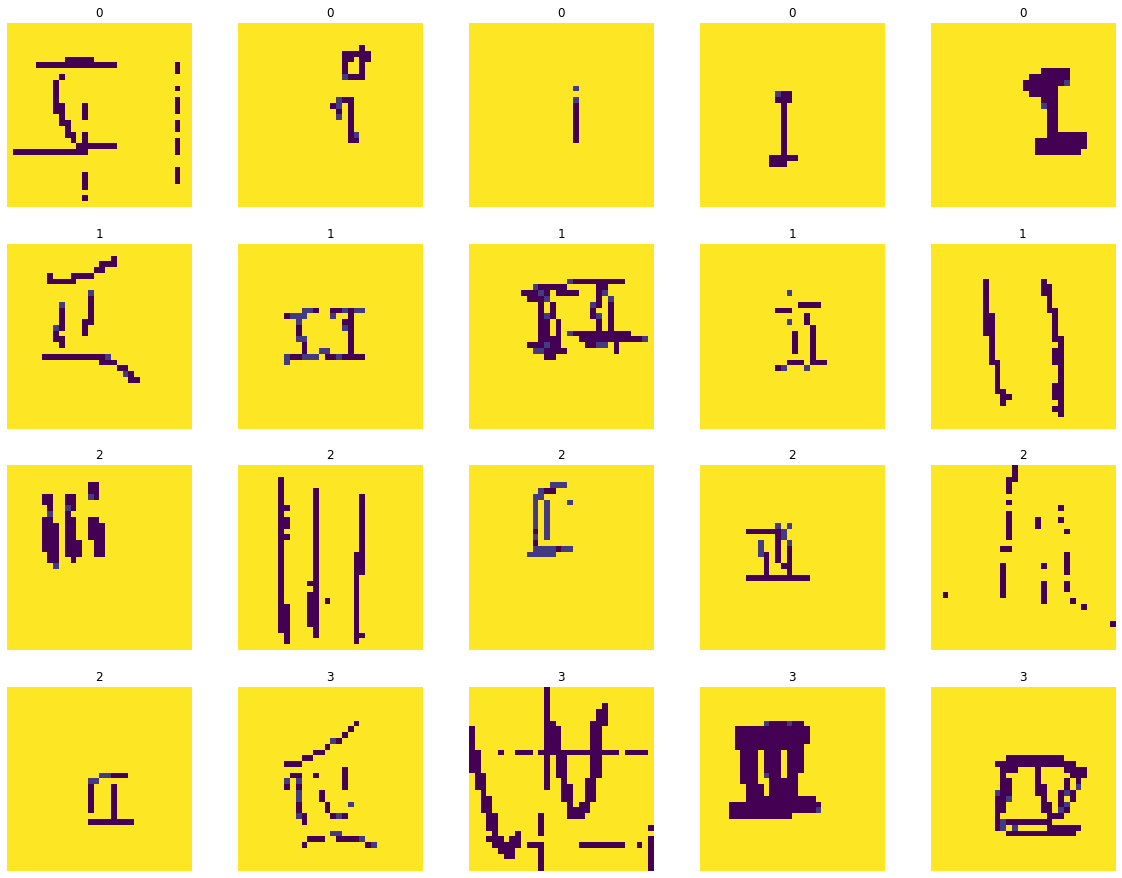

In [ ]:
X_test = prepare_data(DATA_ROOT + 'label_book/')
Y_test = load_labels(DATA_ROOT + 'label_book/')
plot_data(X_test, Y_test)
X_test.shape

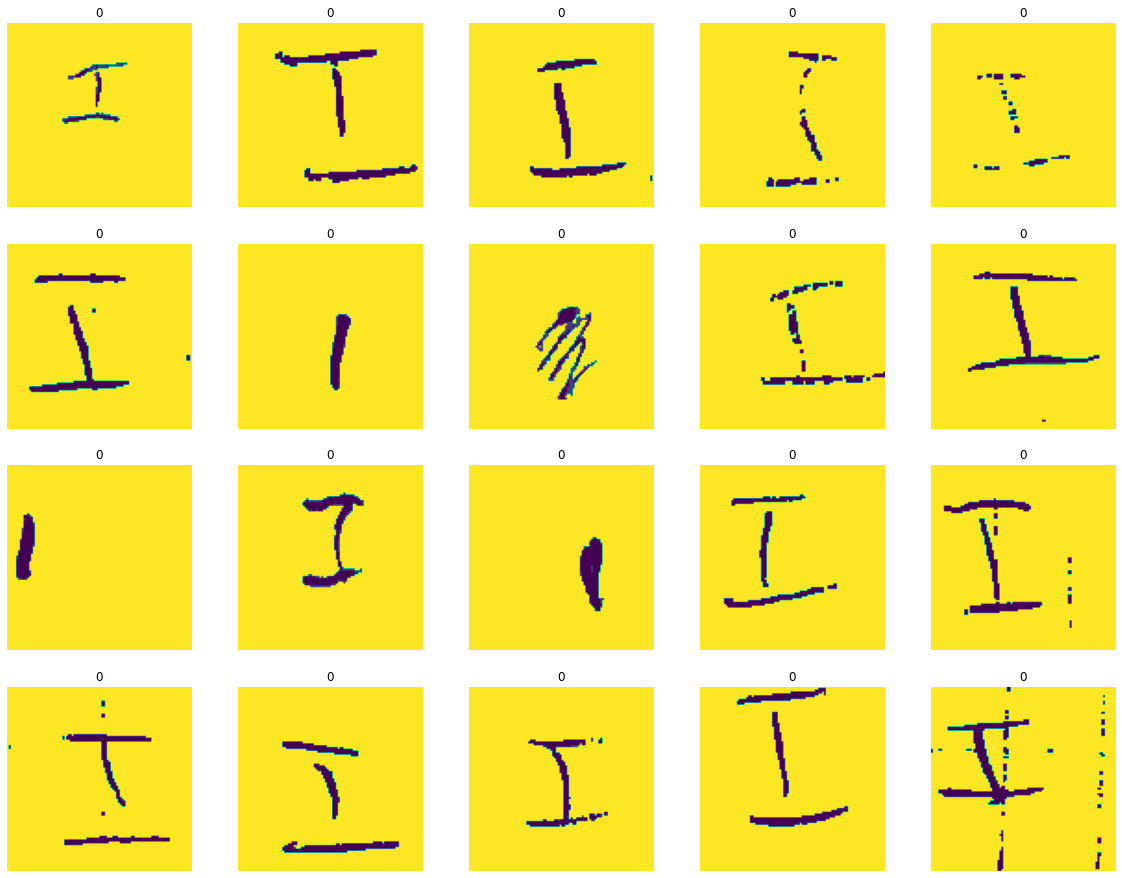

In [ ]:
def plot_data(X, Y, limit=20):
  fig = plt.figure(figsize=(20,40))

  # The number of images for plotting is limited to 50
  end_id = len(Y) if len(Y) < limit else limit

  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.axis('off')
    image = X[i]

    axis.set_title(Y[i])
    axis.imshow(np.clip(image, 0, 1))

plot_data(X_train, Y_train)

# Train
The default training run results in:

training accuracy: 99.37%
validation accuracy: 65.31%
test accuracy: 51.92%

```
Epoch 100/100
259/259 [==============================] - 4s 15ms/step - loss: 0.0216 - accuracy: 0.9937 - val_loss: 1.3546 - val_accuracy: 0.6531
102/102 [==============================] - 1s 8ms/step - loss: 1.3027 - accuracy: 0.6691
final loss 1.3026752471923828, final acc 0.6691266894340515
7/7 [==============================] - 6s 725ms/step - loss: 2.2927 - accuracy: 0.5192
test loss 2.2927401065826416, test acc 0.5192307829856873
```

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys

train_data_path = DATA_ROOT + "/train"
valid_data_path = DATA_ROOT + "/val"
test_data_path = DATA_ROOT + "/label_book" # this can be the label book, or any other test set you create

### DO NOT MODIFY BELOW THIS LINE, THIS IS THE FIXED MODEL ###
batch_size = 8
tf.random.set_seed(123)

def load_data(train_data_path, val_data_path, test_data_path):
  train_data = tf.keras.preprocessing.image_dataset_from_directory(
      train_data_path,
      labels="inferred",
      label_mode="categorical",
      class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
      shuffle=True,
      seed=123,
      batch_size=batch_size,
      image_size=(32, 32),
  )

  val_data = tf.keras.preprocessing.image_dataset_from_directory(
      val_data_path,
      labels="inferred",
      label_mode="categorical",
      class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
      shuffle=True,
      seed=123,
      batch_size=batch_size,
      image_size=(32, 32),
  )

  total_length = ((train_data.cardinality() + val_data.cardinality()) * batch_size).numpy()
  if total_length > 10_000:
      print(f"Dataset size larger than 10,000. Got {total_length} examples")
      sys.exit()

  test_data = tf.keras.preprocessing.image_dataset_from_directory(
      test_data_path,
      labels="inferred",
      label_mode="categorical",
      class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
      shuffle=False,
      seed=123,
      batch_size=batch_size,
      image_size=(32, 32),
  )

  return train_data, val_data, test_data

In [18]:
def train(train_data, val_data, test_data):
  base_model = tf.keras.applications.ResNet50(
      input_shape=(32, 32, 3),
      include_top=False,
      weights=None,
  )
  base_model = tf.keras.Model(
      base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
  )

  inputs = tf.keras.Input(shape=(32, 32, 3))
  x = tf.keras.applications.resnet.preprocess_input(inputs)
  x = base_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(10)(x)
  model = tf.keras.Model(inputs, x)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=0.0001),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=["accuracy"],
  )
  model.summary()
  loss_0, acc_0 = model.evaluate(val_data)
  print(f"loss {loss_0}, acc {acc_0}")

  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      "best_model",
      monitor="val_accuracy",
      mode="max",
      save_best_only=True,
      save_weights_only=True,
  )

  history = model.fit(
      train_data,
      validation_data=val_data,
      epochs=100,
      callbacks=[checkpoint],
  )

  model.load_weights("best_model")

  loss, acc = model.evaluate(val_data)
  print(f"final loss {loss}, final acc {acc}")

  test_loss, test_acc = model.evaluate(test_data)
  print(f"test loss {test_loss}, test acc {test_acc}")

  return model

In [19]:
train_data, val_data, test_data = load_data(DATA_ROOT + "train", DATA_ROOT + "val", DATA_ROOT + "label_book")
model_base = train(train_data, val_data, test_data)


Found 2067 files belonging to 10 classes.
Found 813 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 32, 32, 3)         0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 32, 32, 3)         0         
_________________________________________________________________
model_2 (Functional)         (None, 8, 8, 256)         229760    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 232,330
Trainable params: 229,386
Non-trainable params: 2,944
_________________________________________________

In [21]:
model_base.save_weights('model_base_weights.h5')
model_base.save('model_base.pb')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model_base.pb/assets


In [20]:
train_data_1, val_data_1, test_data_1 = load_data(DATA_ROOT + "train_1", DATA_ROOT + "val_1", DATA_ROOT + "label_book_1")
model_1 = train(train_data_1, val_data_1, test_data_1)

Found 2067 files belonging to 10 classes.
Found 813 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 32, 32, 3)         0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 32, 32, 3)         0         
_________________________________________________________________
model_4 (Functional)         (None, 8, 8, 256)         229760    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 232,330
Trainable params: 229,386
Non-trainable params: 2,944
_________________________________________________

In [24]:
predictions = model_base.predict(test_data)

In [27]:
predictions[0]

array([ 9.434172  , -1.9501066 , -1.1735278 ,  0.51709306,  1.7483507 ,
       -0.9250262 , -6.847113  , -5.5337515 , -2.560023  , -5.356756  ],
      dtype=float32)

In [31]:
actual = [np.argmax(pred) for pred in predictions]

In [52]:
expected = [np.argmax(y) for _, Y in test_data for y in Y]

In [1]:
def comp_predictions(expected, actual):
  results = {}
  for a, e in zip(actual, expected):
    if a != e:
      print("Expected: {} Actual: {}".format(e, a))
    results[actual] 


In [54]:
comp_predictions(expected, actual)

Expected: 1 Actual: 2
Expected: 2 Actual: 7
Expected: 2 Actual: 1
Expected: 2 Actual: 3
Expected: 2 Actual: 3
Expected: 3 Actual: 4
Expected: 8 Actual: 3
Expected: 8 Actual: 5
Expected: 4 Actual: 0
Expected: 5 Actual: 0
Expected: 6 Actual: 2
Expected: 6 Actual: 2
Expected: 6 Actual: 2
Expected: 7 Actual: 2
Expected: 9 Actual: 0


In [46]:
def enumerate_dataset(dataset):
  for X, Y in dataset:
    # print(Y.shape)
    for y in Y:
      print(np.argmax(y))

In [47]:
enumerate_dataset(test_data)

0
0
0
0
0
1
1
1
1
1
2
2
2
2
2
2
3
3
3
3
3
8
8
8
8
8
4
4
4
4
4
4
5
5
5
5
5
6
6
6
6
6
7
7
7
7
7
9
9
9
9
9


In [22]:
amodel_1.save_weights('model_1_weights.h5')
model_1.save('model_1.pb')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model_1.pb/assets


# PCA through feature maps

## VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from sklearn import preprocessing  # to normalise existing X

def get_feature_maps(input):
    # i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    # x = tf.cast(i, tf.float32)
    # x = tf.keras.applications.mobilenet.preprocess_input(x)
    # #Convert to VGG input format
    # NB: This messes up the existing data so skipping it
    #   similarity measures do not seem to be affected by this.
    vgg_input = preprocess_input(input)
    

    #include_top=False == not getting VGG16 last 3 layers
    model = VGG16(weights = "imagenet", include_top=False,
                  input_shape = (input.shape[1], input.shape[2], 3))
    # model = VGG16(weights = None, include_top=False,
    #               input_shape = (input.shape[1], input.shape[2], 1))

    #Get features
    feature_maps = model.predict(vgg_input)
    # feature_maps = model.predict(input)

    return feature_maps, model

# def get_feature_maps(X):
#     #Convert to VGG input format 
#     x_test = preprocess_input(X)

#     #include_top=False == not getting VGG16 last 3 layers
#     model = VGG16(weights = "imagenet", include_top=False)

#     #Get features
#     feature_maps = model.predict(x_test)

#     return feature_maps, model

In [ ]:
from FSDL.plate_recognizer.data.cluster import Cluster

X_train_fm, _ = get_feature_maps(X_train)

# X_train_fm_normalized = preprocessing.normalize(X_train_fm.reshape(len(X_train_fm), -1))
# kmeans = KMeans(n_clusters=K, random_state=0)
# X_train_pca_clusters = kmeans.fit(X_train_pca)

K = 10

cluster = Cluster()

X_train_fmpca, pca = cluster.get_pca_reduced(X_train_fm)

X_train_clusters_fmpca, kmeans_fmpca = cluster.get_clusters(X_train_fmpca, K)

# plot_pca_clusters(X_train_fmpca, kmeans_fmpca)
# plot_cluster_histogram(X_train_fmpca_clusters, K)

ValueError: ignored

In [ ]:
X_train.shape

(2067, 224, 224, 3)

In [ ]:
import FSDL.plate_recognizer.utils.plots as plots

# plots.plot_pca_clusters(X_train_reduced, kmeans_x_train)
plots.plot_cluster_histogram(X_train_clusters_fmpca, K)

NameError: ignored

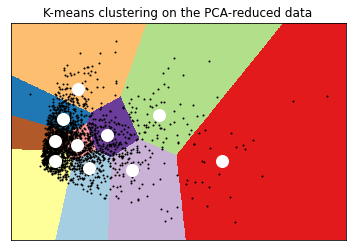

In [ ]:
plots.plot_pca_clusters(X_train_fmpca, kmeans_fmpca)

No handles with labels found to put in legend.


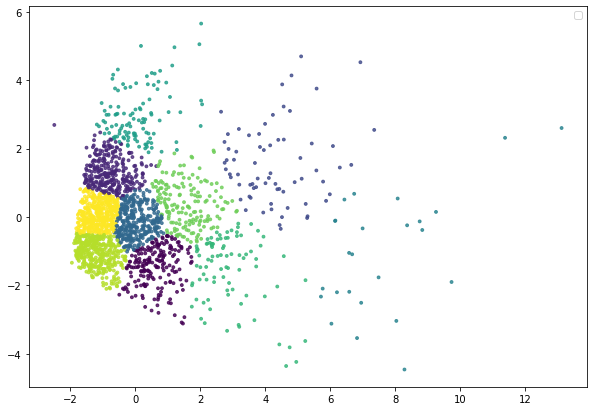

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,7))
plt.scatter(X_train_fmpca[:, 0] , X_train_fmpca[:, 1], c=kmeans_fmpca.labels_ , alpha=0.8, s=8)

plt.legend()
plt.show()

No handles with labels found to put in legend.


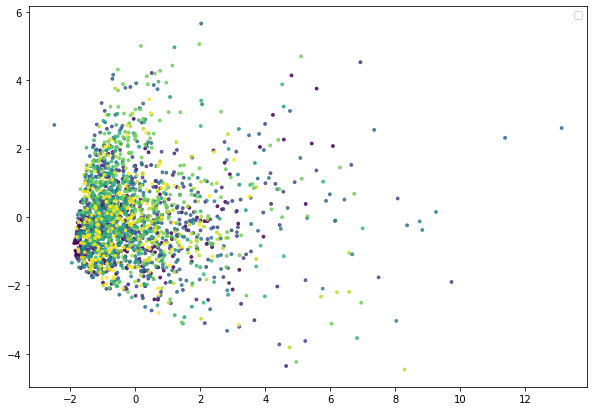

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train_fmpca[:, 0] , X_train_fmpca[:, 1], c=Y_train , alpha=0.8, s=8)

plt.legend()
plt.show()

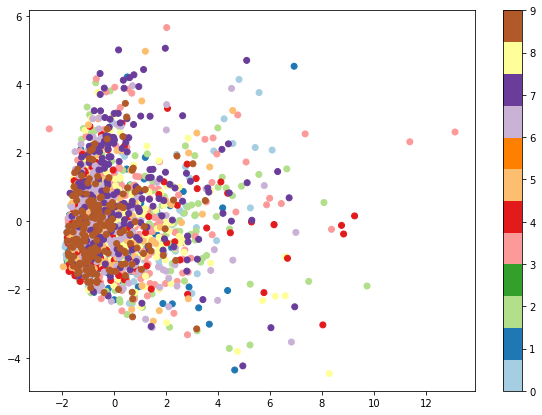

In [ ]:
plt.figure(figsize=(10,7))

plt.figure(1)
plt.clf()

plt.scatter(X_train_fmpca[:, 0], X_train_fmpca[:, 1], c=Y_train, cmap="Paired")
plt.colorbar()

# Clustering through t-SNE

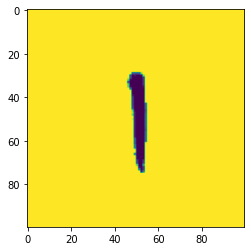

In [ ]:
plt.imshow(X_train[23])

(2067, 10000)

In [ ]:
from sklearn.manifold import TSNE

X_train_flatten = X_train.reshape(X_train.shape[0], -1)

tsne = TSNE(n_components=2, random_state=123, perplexity=10000, n_iter=1000)
tsne_view = tsne.fit_transform(X_train_flatten)

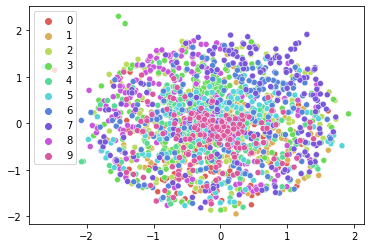

In [ ]:
import seaborn as sns

sns.scatterplot(x = tsne_view[:,0], y = tsne_view[:,1], hue = Y_train, palette = sns.hls_palette(10), legend = 'full');

In [ ]:
DATA_ROOT

'./drive/MyDrive/data/DataCentric/train/'

# Clustering through PCA

In [ ]:
from FSDL.plate_recognizer.data.cluster import Cluster

K = 10

cluster = Cluster()

X_train_reduced, pca = cluster.get_pca_reduced(X_train)

X_train_clusters, kmeans_x_train = cluster.get_clusters(X_train_reduced, K)

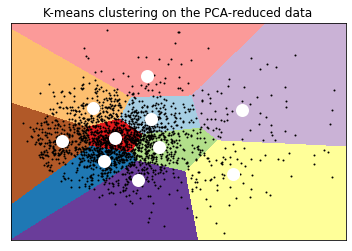

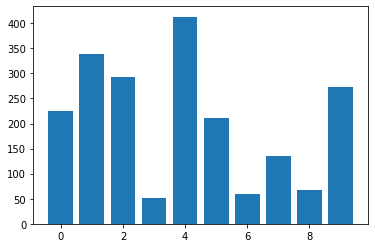

In [ ]:
import FSDL.plate_recognizer.utils.plots as plots

plots.plot_pca_clusters(X_train_reduced, kmeans_x_train)
plots.plot_cluster_histogram(X_train_clusters, K)

No handles with labels found to put in legend.


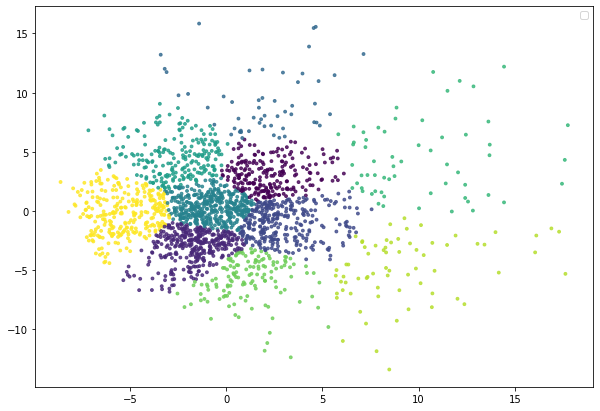

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,7))
plt.scatter(X_train_reduced[:, 0] , X_train_reduced[:, 1], c=kmeans_x_train.labels_ , alpha=0.8, s=8)

plt.legend()
plt.show()

No handles with labels found to put in legend.


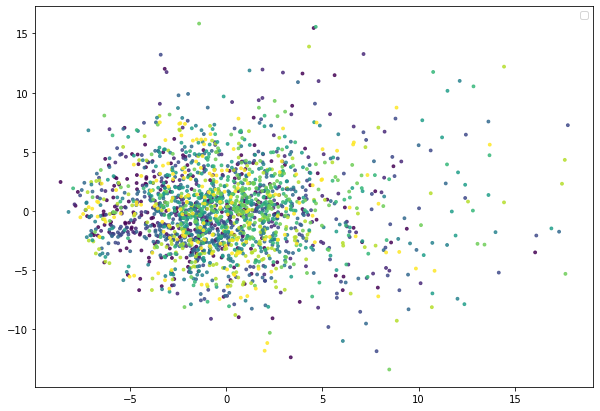

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,7))
# plt.scatter(X_train_reduced[:, 0] , X_train_reduced[:, 1], c=kmeans_x_train.labels_ , alpha=0.8, s=8)
plt.scatter(X_train_reduced[:, 0] , X_train_reduced[:, 1], c=Y_train , alpha=0.8, s=8)

plt.legend()
plt.show()

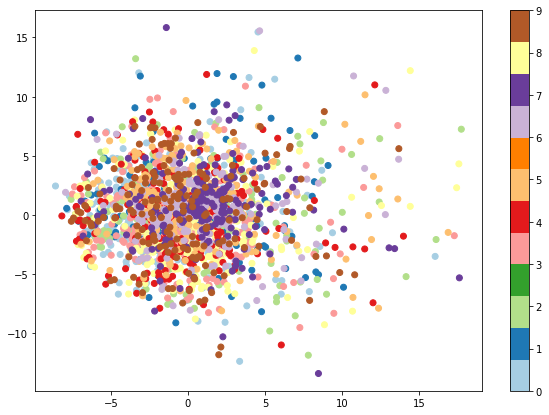

In [ ]:
plt.figure(figsize=(10,7))

plt.figure(1)
plt.clf()

plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=Y_train, cmap="Paired")
plt.colorbar()

## 3D Plotting

This is taken from [sbrouil](https://sbrouil.github.io/ml-sandbox/MNIST+Kaggle+Digit+clusterization+using+KMeans.html)

https://github.com/sbrouil/ml-sandbox/blob/master/kaggle_mnist_cluster_explore.ipynb

In [ ]:
cluster3d = Cluster(dimensions=3)

X_train_reduced3d, pca3d = cluster3d.get_pca_reduced(X_train_raw)

In [ ]:
from IPython.display import display, clear_output
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import plotly
import plotly.offline as py

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

def plot_pca_3d(points, out):
    scatter = {
        'mode':"markers",
        'name': "y",
        'type': "scatter3d",    
        'x': points[:,0], 
        'y': points[:,1], 
        'z': points[:,2],
        'marker': {'size':2, 'color':out, 'colorscale':'Rainbow'}
    }
    fig = {'data':[scatter], 'layout': {'title':"Digits 3 principal components"}}
    # py.iplot(fig)
    py.offline.iplot(fig)


    # plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
# plotly.offline.iplot(plot_figure)

In [ ]:
plot_pca_3d(X_train_reduced3d, Y)

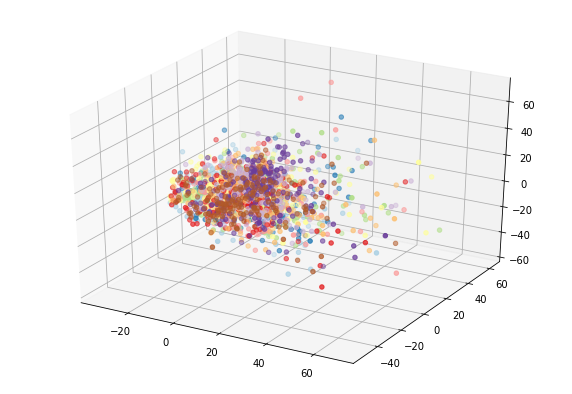

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
# ax = plt.axes(projection='3d')

ax.scatter3D(X_train_reduced3d[:, 0], X_train_reduced3d[:, 1], X_train_reduced3d[:, 2], c=Y, cmap='Paired');
